In [19]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.

import torch
import numpy as np

# Torch functions 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
predir = 'C:/Users/18383/Desktop/stat37601/'
datadir='C:/Users/18383/Desktop/stat37601/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Get Mnist data and split into train validation and test

In [20]:
def get_mnist():

    
    data=np.float64(np.load(datadir+'MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    print(data.shape)
    permutation = np.random.permutation(data.shape[0])
    data = data[permutation]
    labels = labels[permutation]
    data=np.float32(data)/255.
    train_dat=data[0:55000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

### Get cifar10 data and split into training, validation and testing.

In [21]:
import h5py

def get_cifar():
    with h5py.File(datadir+'cifar10_train.hdf5', "r") as f:
        tr=f[('data')][:].transpose(0,3,1,2)
        tr_lb=f[('labels')][:]
    train_data=np.float32(tr[0:45000])/255.
    train_labels=tr_lb[0:45000]
    val_data=np.float32(tr[45000:])/255.
    val_labels=tr_lb[45000:]
    
    with h5py.File(datadir+'cifar10_test.hdf5', "r") as f:
        test_data=f[('data')][:].transpose(0,3,1,2)
        test_data=np.float32(test_data)/255.
        test_labels=f[('labels')][:]
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)


### Get the data 

In [22]:
def get_data(data_set):
    if (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="cifar"):
        return(get_cifar())

### The network

In [23]:
class MNIST_Net(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        

# Run one epoch

In [24]:
def run_epoch(net,epoch,train,pars,num=None,ttype="train"):
    
    
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0

        for j in trange(0,n,pars.batch_size):
                
                # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
                data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(pars.device)
                targ=torch.torch.from_numpy(y[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                
                # Implement SGD step on batch
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                

        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))
        
    return train_loss, 100. * train_correct / len(y)

    


In [25]:
def net_test(net,val,pars,ttype='val'):
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),pars.batch_size):
                    data=torch.from_numpy(vald[j:j+pars.batch_size]).to(device)
                    targ = torch.from_numpy(yval[j:j+pars.batch_size]).type(torch.long).to(pars.device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
    return test_loss, 100. * test_correct / len(yval)



# Run the training. Save the model and test at the end

In [26]:
import time
# An object containing the relevant parameters for running the experiment.
class par(object):
    def __init__(self):
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=10
        self.numtrain=55000
        self.minimizer="Adam"
        self.data_set="mnist"
        self.model_name="model"
        self.dropout=0.
        self.dim=32
        self.pool_size=2
        self.kernel_size=5
        self.mid_layer=256
        self.use_gpu=False

pars=par()

In [27]:
pars.__dict__

{'batch_size': 1000,
 'step_size': 0.001,
 'num_epochs': 10,
 'numtrain': 55000,
 'minimizer': 'Adam',
 'data_set': 'mnist',
 'model_name': 'model',
 'dropout': 0.0,
 'dim': 32,
 'pool_size': 2,
 'kernel_size': 5,
 'mid_layer': 256,
 'use_gpu': False}

In [28]:
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)



net_test(net,test,pars,ttype="test")

# Save the model to a file
if not os.path.isdir(os.path.join(predir,'tmp')):
    os.mkdir(os.path.join(predir,'tmp'))
torch.save(net.state_dict(), os.path.join(predir,'tmp',pars.model_name))

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0006, Accuracy: 45618/55000 (82.94%)


Validation set: Avg. loss: 0.0002, Accuracy: 4707/5000 (94.14%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 52759/55000 (95.93%)


Validation set: Avg. loss: 0.0001, Accuracy: 4865/5000 (97.30%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53666/55000 (97.57%)


Validation set: Avg. loss: 0.0001, Accuracy: 4895/5000 (97.90%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53952/55000 (98.09%)


Validation set: Avg. loss: 0.0001, Accuracy: 4901/5000 (98.02%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 54135/55000 (98.43%)


Validation set: Avg. loss: 0.0001, Accuracy: 4910/5000 (98.20%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54272/55000 (98.68%)


Validation set: Avg. loss: 0.0001, Accuracy: 4917/5000 (98.34%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54370/55000 (98.85%)


Validation set: Avg. loss: 0.0000, Accuracy: 4930/5000 (98.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54459/55000 (99.02%)


Validation set: Avg. loss: 0.0000, Accuracy: 4937/5000 (98.74%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54546/55000 (99.17%)


Validation set: Avg. loss: 0.0000, Accuracy: 4943/5000 (98.86%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54630/55000 (99.33%)


Validation set: Avg. loss: 0.0000, Accuracy: 4938/5000 (98.76%)


Test set: Avg. loss: 0.0000, Accuracy: 9899/10000 (98.99%)



# Reload the model that was saved and continue training

In [29]:
train,val,test=get_data(data_set=pars.data_set)
pars.new_model_name = 'model_continue'
pars.inp_dim=train[0][0].shape
net = MNIST_Net(pars).to(pars.device)

print(pars.__dict__)
state_dict = torch.load(datadir+'tmp/'+pars.model_name, map_location = 'cpu')
net.load_state_dict(state_dict)
net.eval()
for i in range(pars.num_epochs):
    run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
    net_test(net,val,pars)

net_test(net,test,pars, ttype="test")
#save model
torch.save(net.state_dict(), datadir+"tmp/"+pars.model_name)

(70000, 784)
conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738
{'batch_size': 1000, 'step_size': 0.001, 'num_epochs': 10, 'numtrain': 55000, 'minimizer': 'Adam', 'data_set': 'mnist', 'model_name': 'model', 'dropout': 0.0, 'dim': 32, 'pool_size': 2, 'kernel_size': [5, 5], 'mid_layer': 256, 'use_gpu': False, 'device': device(type='cuda', index=0), 'inp_dim': (1, 28, 28), 'new_model_name': 'model_continue'}


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0000, Accuracy: 54402/55000 (98.91%)


Validation set: Avg. loss: 0.0000, Accuracy: 4950/5000 (99.00%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0000, Accuracy: 54639/55000 (99.34%)


Validation set: Avg. loss: 0.0000, Accuracy: 4945/5000 (98.90%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 54681/55000 (99.42%)


Validation set: Avg. loss: 0.0000, Accuracy: 4959/5000 (99.18%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54781/55000 (99.60%)


Validation set: Avg. loss: 0.0000, Accuracy: 4963/5000 (99.26%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54793/55000 (99.62%)


Validation set: Avg. loss: 0.0000, Accuracy: 4962/5000 (99.24%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54848/55000 (99.72%)


Validation set: Avg. loss: 0.0000, Accuracy: 4957/5000 (99.14%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54886/55000 (99.79%)


Validation set: Avg. loss: 0.0000, Accuracy: 4961/5000 (99.22%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54835/55000 (99.70%)


Validation set: Avg. loss: 0.0000, Accuracy: 4960/5000 (99.20%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54898/55000 (99.81%)


Validation set: Avg. loss: 0.0000, Accuracy: 4963/5000 (99.26%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54907/55000 (99.83%)


Validation set: Avg. loss: 0.0000, Accuracy: 4957/5000 (99.14%)


Test set: Avg. loss: 0.0000, Accuracy: 9922/10000 (99.22%)



### Shift the mnist data randomly in both coordinates and create new perturbed test set.


In [30]:
import pylab as py
def get_mnist_trans(test,shift):
    ll=test.shape[0]
    shift2=shift//2
    uu=np.int32((np.random.rand(ll,2)-.5)*shift)
    test_t=[]
    for i,t in enumerate(test):
        tt=np.zeros((28+shift+1,28+shift+1))
        tt[shift2:shift2+28,shift2:shift2+28]=t
        ttt=tt[shift2+uu[i,0]:shift2+uu[i,0]+28,shift2+uu[i,1]:shift2+uu[i,1]+28]
        test_t.append(ttt.reshape(1,28,28))
    test_trans_dat=np.float32(np.concatenate(test_t,axis=0).reshape((-1,1,28,28)))
    for j in range(20):
      py.subplot(1,20,j+1)
      py.imshow(test_trans_dat[j,0])
      py.axis('off')
    py.show()
    print(test_trans_dat.shape)
    return test_trans_dat

## 1.a
Conv1 layer: 1 * 5 * 5 * 32 + 32 (bias terms) = 832 parameters.
Conv2 layer: 32 * 5 * 5 * 64 + 64 (bias terms) = 51,264 parameters.
Fc1 layer: The input dimension (self.inp) is calculated during the first forward pass, and the output dimension is 256 (self.mid_layer). Based on the provided input, I assume the input dimension is 7 * 7 * 64 = 3136 (since MNIST images are 28x28, and after two pooling layers with stride 2, the spatial dimensions are reduced to 7x7). So, the total number of parameters in fc1 is 3136 * 256 + 256 (bias terms) = 803,072 parameters.
Fc_final layer: The input dimension is 256 (self.mid_layer), and the output dimension is 10. So, the total number of parameters in fc_final is 256 * 10 + 10 (bias terms) = 2570 parameters.
The total number of parameters in the model is the sum of the parameters in conv1, conv2, fc1, and fc_final, which is 832 + 51,264 + 803,072 + 2570 = 857,738 parameters.



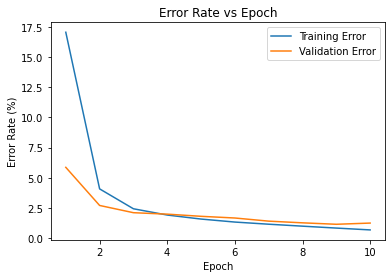

In [31]:
import matplotlib.pyplot as plt
epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(val_accuracies), label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

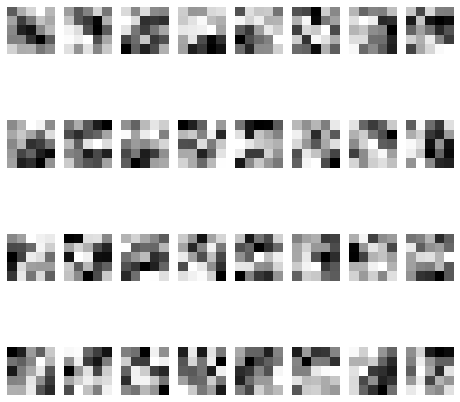

In [32]:
def visualize_filters(net):
    # Get the weights of the first conv layer
    weight_tensor = net.conv1.weight.data.cpu()

    # Create a grid of subplots
    fig, axarr = plt.subplots(4, 8, figsize=(8, 8))

    # Plot each filter as an image
    for i in range(4):
        for j in range(8):
            ax = axarr[i, j]
            ax.imshow(weight_tensor[i * 8 + j, 0, :, :], cmap="gray")
            ax.axis('off')

    plt.show()

# Visualize the filters of the first layer
visualize_filters(net)

## 1.b

(70000, 784)
conv1 torch.Size([1, 16, 14, 14])
conv2 torch.Size([1, 32, 7, 7])
input dimension to fc1 1568
conv1.weight torch.Size([16, 1, 5, 5])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 5, 5])
conv2.bias torch.Size([32])
fc1.weight torch.Size([256, 1568])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 417482


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0008, Accuracy: 44167/55000 (80.30%)


Validation set: Avg. loss: 0.0003, Accuracy: 4616/5000 (92.32%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 51846/55000 (94.27%)


Validation set: Avg. loss: 0.0001, Accuracy: 4777/5000 (95.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 53104/55000 (96.55%)


Validation set: Avg. loss: 0.0001, Accuracy: 4839/5000 (96.78%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53584/55000 (97.43%)


Validation set: Avg. loss: 0.0001, Accuracy: 4882/5000 (97.64%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 53910/55000 (98.02%)


Validation set: Avg. loss: 0.0001, Accuracy: 4909/5000 (98.18%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 54094/55000 (98.35%)


Validation set: Avg. loss: 0.0001, Accuracy: 4916/5000 (98.32%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54203/55000 (98.55%)


Validation set: Avg. loss: 0.0000, Accuracy: 4930/5000 (98.60%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54309/55000 (98.74%)


Validation set: Avg. loss: 0.0000, Accuracy: 4940/5000 (98.80%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54394/55000 (98.90%)


Validation set: Avg. loss: 0.0000, Accuracy: 4941/5000 (98.82%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54426/55000 (98.96%)


Validation set: Avg. loss: 0.0000, Accuracy: 4947/5000 (98.94%)


Test set: Avg. loss: 0.0000, Accuracy: 9905/10000 (99.05%)



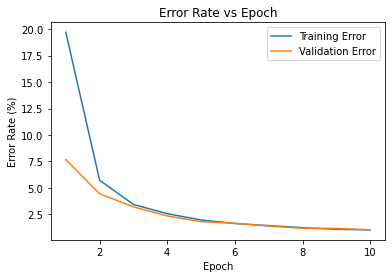

In [33]:
class MNIST_Net_half(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net_half, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 16, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net_half = MNIST_Net_half(pars).to(pars.device)
# Post it to the gpu if its there.
net_half.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net_half,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net_half,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)



net_test(net_half,test,pars,ttype="test")

epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(val_accuracies), label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

(70000, 784)
conv1 torch.Size([1, 64, 14, 14])
conv2 torch.Size([1, 128, 7, 7])
input dimension to fc1 6272
conv1.weight torch.Size([64, 1, 5, 5])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 5, 5])
conv2.bias torch.Size([128])
fc1.weight torch.Size([256, 6272])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1815050


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0005, Accuracy: 46803/55000 (85.10%)


Validation set: Avg. loss: 0.0001, Accuracy: 4797/5000 (95.94%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 53669/55000 (97.58%)


Validation set: Avg. loss: 0.0001, Accuracy: 4891/5000 (97.82%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 54202/55000 (98.55%)


Validation set: Avg. loss: 0.0001, Accuracy: 4916/5000 (98.32%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 54451/55000 (99.00%)


Validation set: Avg. loss: 0.0001, Accuracy: 4918/5000 (98.36%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 54537/55000 (99.16%)


Validation set: Avg. loss: 0.0000, Accuracy: 4933/5000 (98.66%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 54656/55000 (99.37%)


Validation set: Avg. loss: 0.0000, Accuracy: 4939/5000 (98.78%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54681/55000 (99.42%)


Validation set: Avg. loss: 0.0000, Accuracy: 4948/5000 (98.96%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54735/55000 (99.52%)


Validation set: Avg. loss: 0.0000, Accuracy: 4938/5000 (98.76%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54759/55000 (99.56%)


Validation set: Avg. loss: 0.0000, Accuracy: 4945/5000 (98.90%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54852/55000 (99.73%)


Validation set: Avg. loss: 0.0000, Accuracy: 4948/5000 (98.96%)


Test set: Avg. loss: 0.0000, Accuracy: 9910/10000 (99.10%)



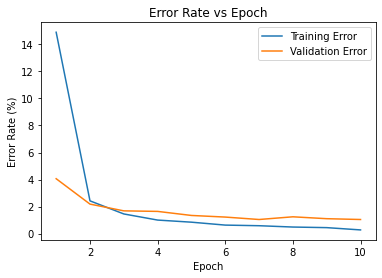

In [34]:
class MNIST_Net_double(nn.Module):
    def __init__(self,pars):
        super(MNIST_Net_double, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(1, 64, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net_double = MNIST_Net_double(pars).to(pars.device)
# Post it to the gpu if its there.
net_double.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net_double,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net_double,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)



net_test(net_double,test,pars,ttype="test")

epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(val_accuracies), label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

(70000, 784)


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0009, Accuracy: 39602/55000 (72.00%)


Validation set: Avg. loss: 0.0003, Accuracy: 4508/5000 (90.16%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 50833/55000 (92.42%)


Validation set: Avg. loss: 0.0002, Accuracy: 4727/5000 (94.54%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 52818/55000 (96.03%)


Validation set: Avg. loss: 0.0001, Accuracy: 4857/5000 (97.14%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53560/55000 (97.38%)


Validation set: Avg. loss: 0.0001, Accuracy: 4898/5000 (97.96%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 53864/55000 (97.93%)


Validation set: Avg. loss: 0.0001, Accuracy: 4899/5000 (97.98%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 54067/55000 (98.30%)


Validation set: Avg. loss: 0.0001, Accuracy: 4912/5000 (98.24%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 54208/55000 (98.56%)


Validation set: Avg. loss: 0.0001, Accuracy: 4918/5000 (98.36%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 54288/55000 (98.71%)


Validation set: Avg. loss: 0.0000, Accuracy: 4925/5000 (98.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54413/55000 (98.93%)


Validation set: Avg. loss: 0.0000, Accuracy: 4925/5000 (98.50%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54468/55000 (99.03%)


Validation set: Avg. loss: 0.0000, Accuracy: 4944/5000 (98.88%)


Test set: Avg. loss: 0.0000, Accuracy: 9859/10000 (98.59%)



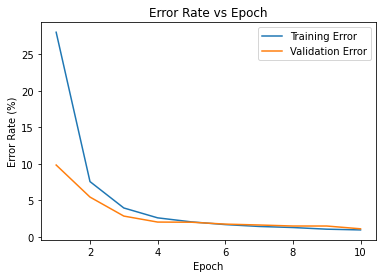

In [35]:
class Deep_MNIST_Net(nn.Module):
    def __init__(self, pars):
        super(Deep_MNIST_Net, self).__init__()

        ks = pars.kernel_size
        ps = np.int32(pars.pool_size)
        self.mid_layer = pars.mid_layer
        self.mid_layer2 = pars.mid_layer // 2

        self.conv1 = nn.Conv2d(1, 16, kernel_size=ks[0], padding=ks[0] // 2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=ks[1], padding=ks[1] // 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=ks[2], padding=ks[2] // 2)
        self.drop2 = nn.Dropout2d(pars.dropout)

        self.first = True
        if self.first:
            self.forward(torch.zeros((1,) + pars.inp_dim))

        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=pars.step_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.drop2(F.relu(self.conv3(x)))

        if self.first:
            self.first = False
            self.inp = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.inp, self.mid_layer)
            self.fc2 = nn.Linear(self.mid_layer, self.mid_layer2)
            self.fc_final = nn.Linear(self.mid_layer2, 10)

        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        
# use GPU when possible
pars.device = device
pars.kernel_size=[3,3,3]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net_deep = Deep_MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net_deep.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net_deep,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net_deep,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)



net_test(net_deep,test,pars,ttype="test")

epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(val_accuracies), label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

From the above experiments, we can see that the model keeping the same number of layers and doubling the number parameters converges fastest and have the smallest test error. Next try it on the full training set and report the result:

(70000, 784)
conv1 torch.Size([1, 64, 14, 14])
conv2 torch.Size([1, 128, 7, 7])
input dimension to fc1 6272
conv1.weight torch.Size([64, 1, 5, 5])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 5, 5])
conv2.bias torch.Size([128])
fc1.weight torch.Size([256, 6272])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1815050


  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0004, Accuracy: 51786/60000 (86.31%)


Validation set: Avg. loss: 0.0001, Accuracy: 9668/10000 (96.68%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0001, Accuracy: 58584/60000 (97.64%)


Validation set: Avg. loss: 0.0001, Accuracy: 9813/10000 (98.13%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0000, Accuracy: 59130/60000 (98.55%)


Validation set: Avg. loss: 0.0000, Accuracy: 9863/10000 (98.63%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0000, Accuracy: 59344/60000 (98.91%)


Validation set: Avg. loss: 0.0000, Accuracy: 9870/10000 (98.70%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0000, Accuracy: 59454/60000 (99.09%)


Validation set: Avg. loss: 0.0000, Accuracy: 9889/10000 (98.89%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0000, Accuracy: 59569/60000 (99.28%)


Validation set: Avg. loss: 0.0000, Accuracy: 9885/10000 (98.85%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0000, Accuracy: 59627/60000 (99.38%)


Validation set: Avg. loss: 0.0000, Accuracy: 9899/10000 (98.99%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0000, Accuracy: 59674/60000 (99.46%)


Validation set: Avg. loss: 0.0000, Accuracy: 9911/10000 (99.11%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 59714/60000 (99.52%)


Validation set: Avg. loss: 0.0000, Accuracy: 9909/10000 (99.09%)



  0%|          | 0/60 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 59766/60000 (99.61%)


Validation set: Avg. loss: 0.0000, Accuracy: 9904/10000 (99.04%)



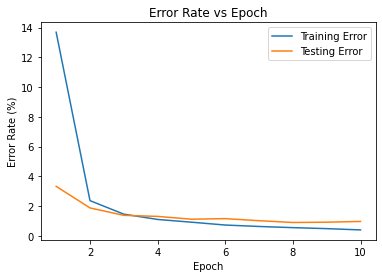

In [36]:
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
pars.numtrain = 60000
train,val,test=get_data(data_set=pars.data_set)
train_data, train_labels = train
val_data, val_labels = val
combined_data = np.concatenate((train_data, val_data), axis=0)
combined_labels = np.concatenate((train_labels, val_labels), axis=0)
train = (combined_data, combined_labels)
pars.inp_dim=train[0][0].shape
# Initialize the network
net_best = MNIST_Net_double(pars).to(pars.device)
# Post it to the gpu if its there.
net_best.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net_best,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    test_loss, test_accuracy = net_test(net_best,test,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


# Save the model to a file
if not os.path.isdir(os.path.join(predir,'tmp')):
    os.mkdir(os.path.join(predir,'tmp'))
torch.save(net_best.state_dict(), os.path.join(predir,'tmp',pars.model_name))

epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(test_accuracies), label="Testing Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

## 1.c

Shift size:0


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9971/10000 (99.71%)

Shift size:2


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9971/10000 (99.71%)

Shift size:4


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0000, Accuracy: 9901/10000 (99.01%)

Shift size:6


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0002, Accuracy: 9624/10000 (96.24%)

Shift size:8


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0006, Accuracy: 8788/10000 (87.88%)

Shift size:10


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0017, Accuracy: 7492/10000 (74.92%)

Shift size:12


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0031, Accuracy: 6232/10000 (62.32%)

Shift size:14


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0047, Accuracy: 5076/10000 (50.76%)

Shift size:16


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0063, Accuracy: 4139/10000 (41.39%)



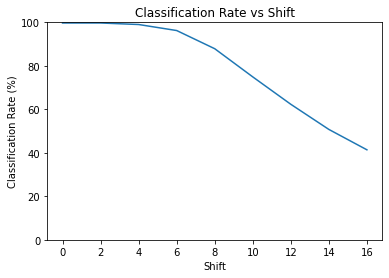

In [37]:
shift_values = np.arange(0, 17, 2)
classification_rates = []

for shift in shift_values:
    print(f"Shift size:{shift}")
    shifted_test_set = get_mnist_trans(test[0], shift)
    newtest = (shifted_test_set,test[1])
    _, classification_rate = net_test(net, newtest, pars, ttype="test")
    classification_rates.append(classification_rate)

plt.plot(shift_values, classification_rates)
plt.xlabel("Shift")
plt.ylabel("Classification Rate (%)")
plt.ylim(0,100)
plt.title("Classification Rate vs Shift")
plt.show()

To improve the network's performance on the transformed test set, you can try the following modifications:

1.Increase the number of convolutional layers and reduce the number of fully connected layers, which may help the network learn more spatially invariant features.

2.Add data augmentation during training, such as random translations, to increase the network's robustness to small shifts.

(70000, 784)


(55000, 1, 28, 28)


(5000, 1, 28, 28)


(10000, 1, 28, 28)


  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0011, Accuracy: 34667/55000 (63.03%)


Validation set: Avg. loss: 0.0003, Accuracy: 4481/5000 (89.62%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0002, Accuracy: 50927/55000 (92.59%)


Validation set: Avg. loss: 0.0002, Accuracy: 4711/5000 (94.22%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0001, Accuracy: 52571/55000 (95.58%)


Validation set: Avg. loss: 0.0001, Accuracy: 4798/5000 (95.96%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0001, Accuracy: 53090/55000 (96.53%)


Validation set: Avg. loss: 0.0001, Accuracy: 4824/5000 (96.48%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0001, Accuracy: 53441/55000 (97.17%)


Validation set: Avg. loss: 0.0001, Accuracy: 4848/5000 (96.96%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0001, Accuracy: 53667/55000 (97.58%)


Validation set: Avg. loss: 0.0001, Accuracy: 4873/5000 (97.46%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 53912/55000 (98.02%)


Validation set: Avg. loss: 0.0001, Accuracy: 4886/5000 (97.72%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 54130/55000 (98.42%)


Validation set: Avg. loss: 0.0001, Accuracy: 4870/5000 (97.40%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0000, Accuracy: 54125/55000 (98.41%)


Validation set: Avg. loss: 0.0001, Accuracy: 4889/5000 (97.78%)



  0%|          | 0/55 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0000, Accuracy: 54308/55000 (98.74%)


Validation set: Avg. loss: 0.0001, Accuracy: 4886/5000 (97.72%)

Shift size:0


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9788/10000 (97.88%)

Shift size:2


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9788/10000 (97.88%)

Shift size:4


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9764/10000 (97.64%)

Shift size:6


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0001, Accuracy: 9713/10000 (97.13%)

Shift size:8


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0002, Accuracy: 9571/10000 (95.71%)

Shift size:10


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0003, Accuracy: 9359/10000 (93.59%)

Shift size:12


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0005, Accuracy: 8944/10000 (89.44%)

Shift size:14


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0008, Accuracy: 8443/10000 (84.43%)

Shift size:16


(10000, 1, 28, 28)

Test set: Avg. loss: 0.0011, Accuracy: 7921/10000 (79.21%)



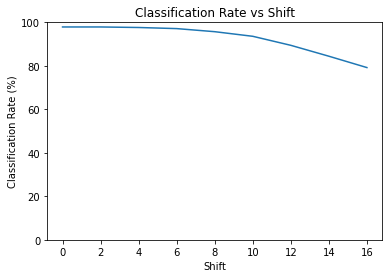

In [38]:
class Improved_MNIST_Net(nn.Module):
    def __init__(self, pars):
        super(Improved_MNIST_Net, self).__init__()

        ks = pars.kernel_size
        ps = np.int32(pars.pool_size)
        self.mid_layer = pars.mid_layer

        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks[0], padding=ks[0] // 2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1], padding=ks[1] // 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=ks[2], padding=ks[2] // 2)
        self.drop2 = nn.Dropout2d(pars.dropout)

        self.first = True
        if self.first:
            self.forward(torch.zeros((1,) + pars.inp_dim))

        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=pars.step_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.drop2(F.relu(self.conv3(x)))

        if self.first:
            self.first = False
            self.inp = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.inp, self.mid_layer)
            self.fc_final = nn.Linear(self.mid_layer, 10)

        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5,5]
pars.numtrain = 55000
train,val,test=get_data(data_set=pars.data_set)
train = (get_mnist_trans(train[0], 10), train[1])
val = (get_mnist_trans(val[0], 10), val[1])
test = (get_mnist_trans(test[0], 10), test[1])
pars.inp_dim=train[0][0].shape
# Initialize the network
net_improved = Improved_MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net_improved.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net_improved,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net_improved,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)



shift_values = np.arange(0, 17, 2)
classification_rates = []

for shift in shift_values:
    print(f"Shift size:{shift}")
    shifted_test_set = get_mnist_trans(test[0], shift)
    newtest = (shifted_test_set,test[1])
    _, classification_rate = net_test(net_improved, newtest, pars, ttype="test")
    classification_rates.append(classification_rate)

plt.plot(shift_values, classification_rates)
plt.xlabel("Shift")
plt.ylabel("Classification Rate (%)")
plt.ylim(0,100)
plt.title("Classification Rate vs Shift")
plt.show()

We can see that after the improvement, the model is more robust when encountering pixel shift.

## 2.a

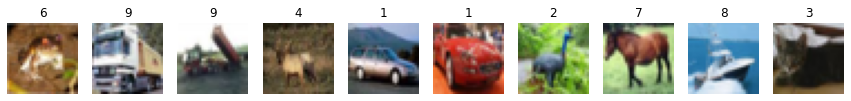

In [39]:
pars.data_set="cifar"
train,val,test=get_data(data_set=pars.data_set)
def display_images(images, labels):
    num_images = labels.shape[0]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Display some of the images
display_images(train[0][:10], train[1][:10])

## 2.b

conv1 torch.Size([1, 32, 16, 16])
conv2 torch.Size([1, 64, 8, 8])
input dimension to fc1 4096
conv1.weight torch.Size([32, 3, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 4096])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 1105098


  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0019, Accuracy: 14542/45000 (32.32%)


Validation set: Avg. loss: 0.0016, Accuracy: 2131/5000 (42.62%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0015, Accuracy: 20865/45000 (46.37%)


Validation set: Avg. loss: 0.0014, Accuracy: 2514/5000 (50.28%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0014, Accuracy: 23046/45000 (51.21%)


Validation set: Avg. loss: 0.0013, Accuracy: 2694/5000 (53.88%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0013, Accuracy: 24788/45000 (55.08%)


Validation set: Avg. loss: 0.0013, Accuracy: 2728/5000 (54.56%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0012, Accuracy: 25948/45000 (57.66%)


Validation set: Avg. loss: 0.0012, Accuracy: 2894/5000 (57.88%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0011, Accuracy: 26898/45000 (59.77%)


Validation set: Avg. loss: 0.0011, Accuracy: 3085/5000 (61.70%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0011, Accuracy: 28076/45000 (62.39%)


Validation set: Avg. loss: 0.0011, Accuracy: 3086/5000 (61.72%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0010, Accuracy: 28504/45000 (63.34%)


Validation set: Avg. loss: 0.0010, Accuracy: 3219/5000 (64.38%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0010, Accuracy: 29385/45000 (65.30%)


Validation set: Avg. loss: 0.0010, Accuracy: 3261/5000 (65.22%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0010, Accuracy: 29810/45000 (66.24%)


Validation set: Avg. loss: 0.0010, Accuracy: 3311/5000 (66.22%)


Test set: Avg. loss: 0.0010, Accuracy: 6444/10000 (64.44%)



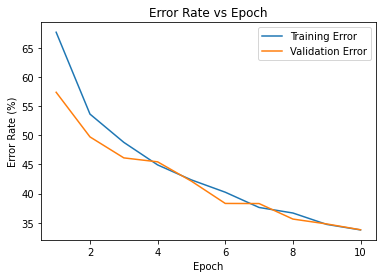

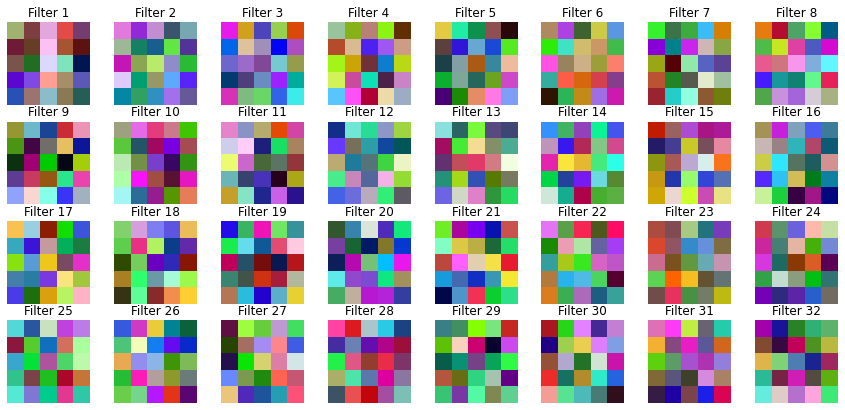

In [51]:

class CIFAR_Net(nn.Module):
    def __init__(self,pars):
        super(CIFAR_Net, self).__init__()
        
        ks=pars.kernel_size
        ps=np.int32(pars.pool_size)
        self.mid_layer=pars.mid_layer
        # Two successive convolutional layers.
        # Two pooling layers that come after convolutional layers.
        # Two dropout layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks[0],padding=ks[0]//2)
        self.pool1=nn.MaxPool2d(kernel_size=[ps],stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1],padding=ks[1]//2)
        self.drop2 = nn.Dropout2d(pars.dropout)
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop_final=nn.Dropout(pars.dropout)
       
               
        
        # Run the network one time on one dummy data point of the same 
        # dimension as the input images to get dimensions of fully connected 
        # layer that comes after second convolutional layers
        self.first=True
        if self.first:
            self.forward(torch.zeros((1,)+pars.inp_dim))
            
        # Setup the optimizer type and send it the parameters of the model
        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = pars.step_size)
         
        self.criterion=nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        # Apply relu to a pooled conv1 layer.
        x = F.relu(self.pool1(self.conv1(x)))
        if self.first:
            print('conv1',x.shape)
        # Apply relu to a pooled conv2 layer with a drop layer inbetween.
        x = self.drop2(F.relu(self.pool2(self.conv2(x))))
        if self.first:
            print('conv2',x.shape)
        
        if self.first:
            self.first=False
            self.inp=x.shape[1]*x.shape[2]*x.shape[3]
            # Compute dimension of output of x and setup a fully connected layer with that input dim 
            # pars.mid_layer output dim. Then setup final 10 node output layer.
            print('input dimension to fc1',self.inp)
            if self.mid_layer is not None:
                self.fc1 = nn.Linear(self.inp, self.mid_layer)
                self.fc_final = nn.Linear(self.mid_layer, 10)
            else:
                self.fc1=nn.Identity()
                self.fc_final = nn.Linear(self.inp, 10)
            # Print out all network parameter shapes and compute total:
            tot_pars=0
            for k,p in self.named_parameters():
                tot_pars+=p.numel()
                print(k,p.shape)
            print('tot_pars',tot_pars)
        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.drop_final(x)
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
               
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = CIFAR_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

net_test(net,test,pars,ttype="test")

epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(val_accuracies), label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

# Plot the first layer filters
filters = net.conv1.weight.detach().cpu().numpy()
num_filters = filters.shape[0]

fig, axes = plt.subplots(4, 8, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        img = filters[i].transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.set_title(f'Filter {i+1}')
    ax.axis('off')
plt.show()

## 2.c

  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0019, Accuracy: 13840/45000 (30.76%)


Validation set: Avg. loss: 0.0016, Accuracy: 2150/5000 (43.00%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0015, Accuracy: 20385/45000 (45.30%)


Validation set: Avg. loss: 0.0014, Accuracy: 2441/5000 (48.82%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0013, Accuracy: 23801/45000 (52.89%)


Validation set: Avg. loss: 0.0013, Accuracy: 2773/5000 (55.46%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0012, Accuracy: 25721/45000 (57.16%)


Validation set: Avg. loss: 0.0012, Accuracy: 2885/5000 (57.70%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0011, Accuracy: 27105/45000 (60.23%)


Validation set: Avg. loss: 0.0011, Accuracy: 3126/5000 (62.52%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0010, Accuracy: 28333/45000 (62.96%)


Validation set: Avg. loss: 0.0010, Accuracy: 3239/5000 (64.78%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0010, Accuracy: 29548/45000 (65.66%)


Validation set: Avg. loss: 0.0010, Accuracy: 3248/5000 (64.96%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0009, Accuracy: 30495/45000 (67.77%)


Validation set: Avg. loss: 0.0009, Accuracy: 3394/5000 (67.88%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0009, Accuracy: 31243/45000 (69.43%)


Validation set: Avg. loss: 0.0009, Accuracy: 3393/5000 (67.86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0008, Accuracy: 32049/45000 (71.22%)


Validation set: Avg. loss: 0.0009, Accuracy: 3434/5000 (68.68%)


Test set: Avg. loss: 0.0009, Accuracy: 6807/10000 (68.07%)



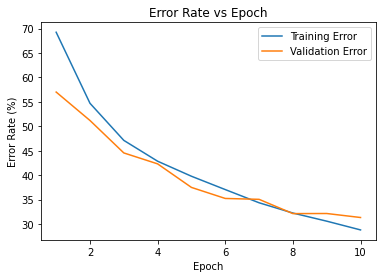

In [52]:
class Improved_CIFAR_Net(nn.Module):
    def __init__(self, pars):
        super(Improved_CIFAR_Net, self).__init__()

        ks = pars.kernel_size
        ps = np.int32(pars.pool_size)
        self.mid_layer = pars.mid_layer

        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks[0], padding=ks[0] // 2)
        self.pool1 = nn.MaxPool2d(kernel_size=[ps], stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks[1], padding=ks[1] // 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=ks[2], padding=ks[2] // 2)
        self.drop2 = nn.Dropout2d(pars.dropout)

        self.first = True
        if self.first:
            self.forward(torch.zeros((1,) + pars.inp_dim))

        if pars.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=pars.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=pars.step_size)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.drop2(F.relu(self.conv3(x)))

        if self.first:
            self.first = False
            self.inp = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.inp, self.mid_layer)
            self.fc_final = nn.Linear(self.mid_layer, 10)

        x = x.reshape(-1, self.inp)
        x = F.relu(self.fc1(x))
        x = self.fc_final(x)
        return x
    
    # Run the network on the data, compute the loss, compute the predictions and compute classification rate/
    def get_acc_and_loss(self, data, targ):
        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
    
    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,data,targ):
    
        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct
    
        
# use GPU when possible
pars.device = device
pars.kernel_size=[5,5,5]
train,val,test=get_data(data_set=pars.data_set)
pars.inp_dim=train[0][0].shape
# Initialize the network
net = Improved_CIFAR_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)


train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for i in range(pars.num_epochs):
    # Run one epoch of training
    train_loss, train_accuracy = run_epoch(net,i,train, pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    val_loss, val_accuracy = net_test(net,val,pars)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

net_test(net,test,pars,ttype="test")

epochs = np.arange(1, pars.num_epochs + 1)
plt.figure()
plt.plot(epochs, 100 - np.array(train_accuracies), label="Training Error")
plt.plot(epochs, 100 - np.array(val_accuracies), label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.title("Error Rate vs Epoch")
plt.show()

There is some improvement but not very large.

## 2.d

In [103]:
from skimage import color
def transform_image(image, min_factor=0.75, max_factor=1.25):
    # Convert RGB to HSV
    hsv_image = color.rgb2hsv(image)
    
    # Apply the saturation transformation
    factor = np.random.uniform(min_factor, max_factor)
    hsv_image[:, :, 1] *= factor
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 1)  # Ensure saturation values are in the range [0, 1]

    # Convert back to RGB
    transformed_image = color.hsv2rgb(hsv_image)

    return transformed_image

test_transformed = np.array([transform_image(img.transpose(1, 2, 0)).transpose(2, 0, 1) for img in test[0]])

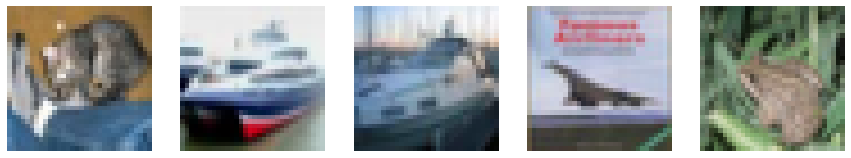

In [83]:
import matplotlib.pyplot as plt

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    axes[i].imshow(test_transformed[i].transpose(1, 2, 0))
    axes[i].axis('off')

plt.show()

In [106]:
net_test(net,(test_transformed,test[1]),pars,ttype="test")


Test set: Avg. loss: 0.0009, Accuracy: 6795/10000 (67.95%)



(0.0009213252246379853, 67.95)

The model is quite robust against the saturation modfication.